In [1]:
import msgpack

def FromMessagePack(filename):
    with open(filename, "rb") as data_file:
        byte_data = data_file.read()
    data_loaded = msgpack.unpackb(byte_data)
    return data_loaded

In [2]:
import torch
import matplotlib.pyplot as plt

id = 1
filename = f"C:\Projects\MMU\Ifosic\src\Python\Set0{id}.msgpack";
data = FromMessagePack(filename)
traces = torch.tensor(data["Traces"])

start = 0
stop = traces.shape[0] - (traces.shape[0] - 1280)
roi = traces[start:stop,:].transpose(0, 1)
print(roi.shape)
# plt.imshow(roi)
indexes = data["BoundaryIndexes"]
print(indexes)

torch.Size([1950, 1280])
[654, 686, 750, 814, 879, 913]


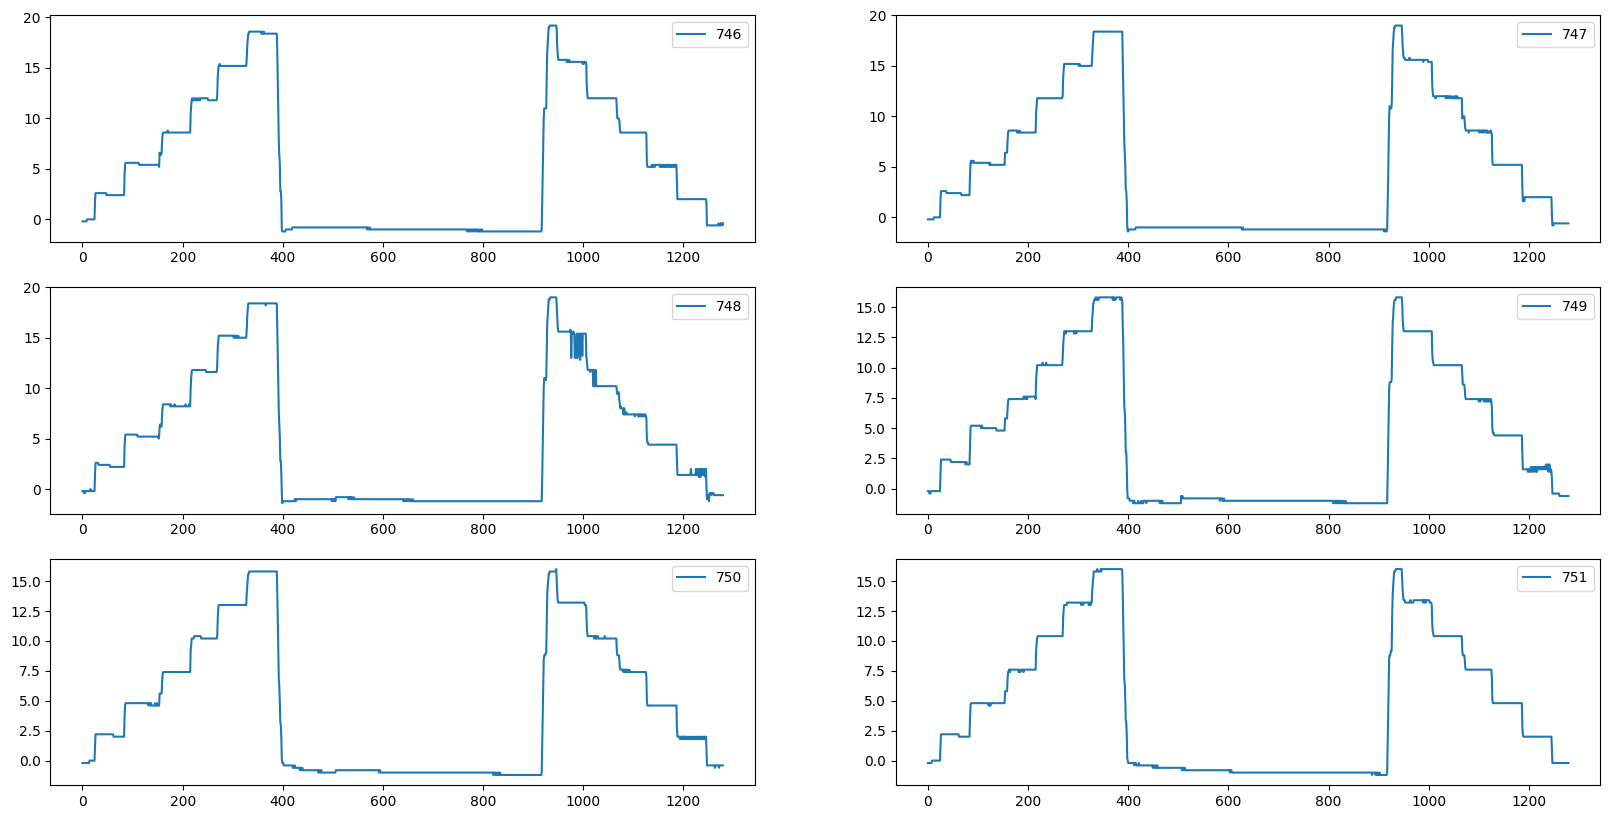

In [112]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import euclidean
import math
plt.rcParams["figure.figsize"] = (20,10)

def signal_plot(c: list):
    n = len(c)
    if n == 1:
        plt.plot(roi[c[0]])
    else:
        cols = 2
        rows = math.ceil(n / 2)
        _, ax = plt.subplots(rows, cols)
        i = 0
        for row in range(rows):
            for col in range(cols):
                if i >= n:
                    break
                v = c[i]
                ax[row, col].plot(roi[v])
                ax[row, col].legend([v])
                i += 1
    plt.show()

signal_plot(np.arange(746,752))

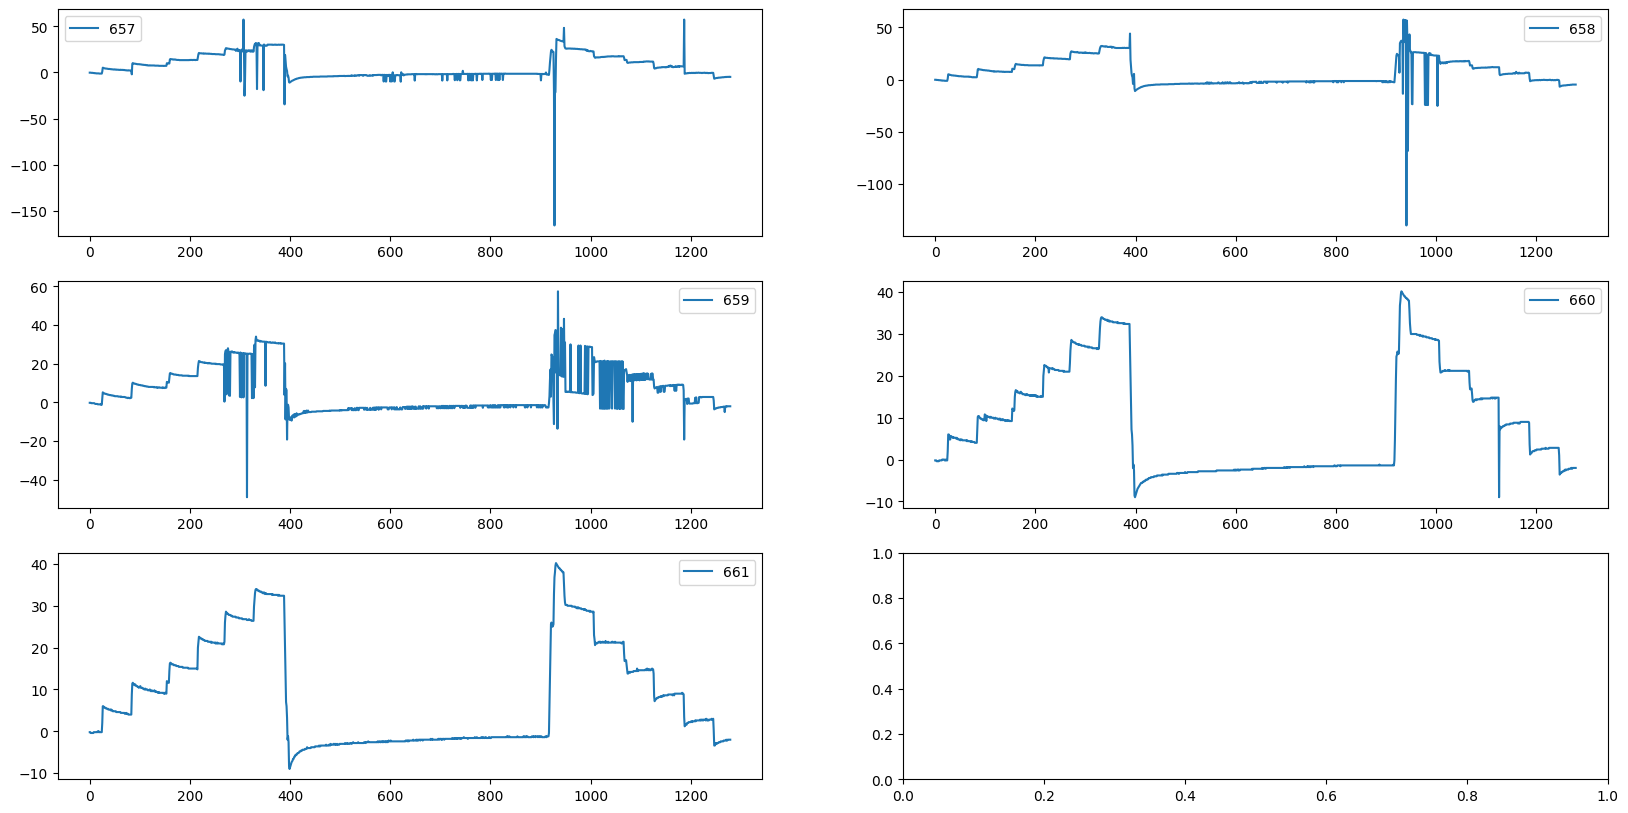

In [222]:
def win(pos = 654, w = 5):
    h = w // 2
    return np.arange(pos-h, pos+h+1)

def data_slider(data: torch.tensor, win = 5):
    h,w = data.shape
    hw = win // 2
    slider = torch.zeros(data.shape[0], win, data.shape[1])
    for i in range(win):
        ss = 0 if i > hw else hw-i
        se = 0 if i < hw else i-hw
        ds = 0 if i < hw else i-hw
        de = 0 if i > hw else hw-i
        # print(ss, se, ds, de)
        slider[ss:h-se,i,:] = data[ds:h-de]

    # slider[2:,0,:] = data[0:-2]
    # slider[1:,1,:] = data[0:-1]
    # slider[:,2,:] = data
    # slider[:data.shape[0]-1,3,:] = data[1:]
    # slider[:data.shape[0]-2,4,:] = data[2:]
    return slider

def signal_plot(data: torch.tensor, idx = 0):
    b,c,w = data.shape
    win = data[idx]
    if c == 1:
        plt.plot(win[0])
    else:
        cols = 2
        rows = math.ceil(c / 2)
        _, ax = plt.subplots(rows, cols)
        i = 0
        for row in range(rows):
            for col in range(cols):
                if i >= c:
                    break
                v = idx-2+i
                ax[row, col].plot(win[i])
                ax[row, col].legend([v])
                i += 1
    plt.show()


sliders = data_slider(roi)
signal_plot(sliders, idx = 659)
# print(roi[:].shape)

[499.3885498046875, 628.111083984375, 384.8537292480469, 762.9971313476562, 876.091064453125, 422.76654052734375, 198.7123565673828, 20.02398681640625, 30.75516128540039, 4.4631829261779785, 47.40885925292969, 18.372806549072266, 8.872428894042969, 21.215089797973633, 20.26622772216797, 13.4447021484375, 64.44377136230469, 8.78635311126709, 44.61614227294922, 15.812653541564941, 25.358234405517578, 24.09730339050293, 12.129303932189941, 39.520626068115234, 53.63170623779297, 242.38812255859375, 796.368896484375, 925.6201782226562, 481.0755310058594, 213.61395263671875, 642.0137329101562, 986.4095458984375, 903.7249145507812, 642.019775390625, 756.8250732421875, 1241.2615966796875, 1137.9306640625, 168.04356384277344, 84.88768768310547, 159.74517822265625, 234.6282196044922, 494.3042297363281, 466.79180908203125, 156.72894287109375, 616.197021484375, 823.8900756835938, 1035.9320068359375, 1492.8734130859375, 1829.272705078125, 913.4891967773438, 140.6106719970703, 79.47981262207031, 154

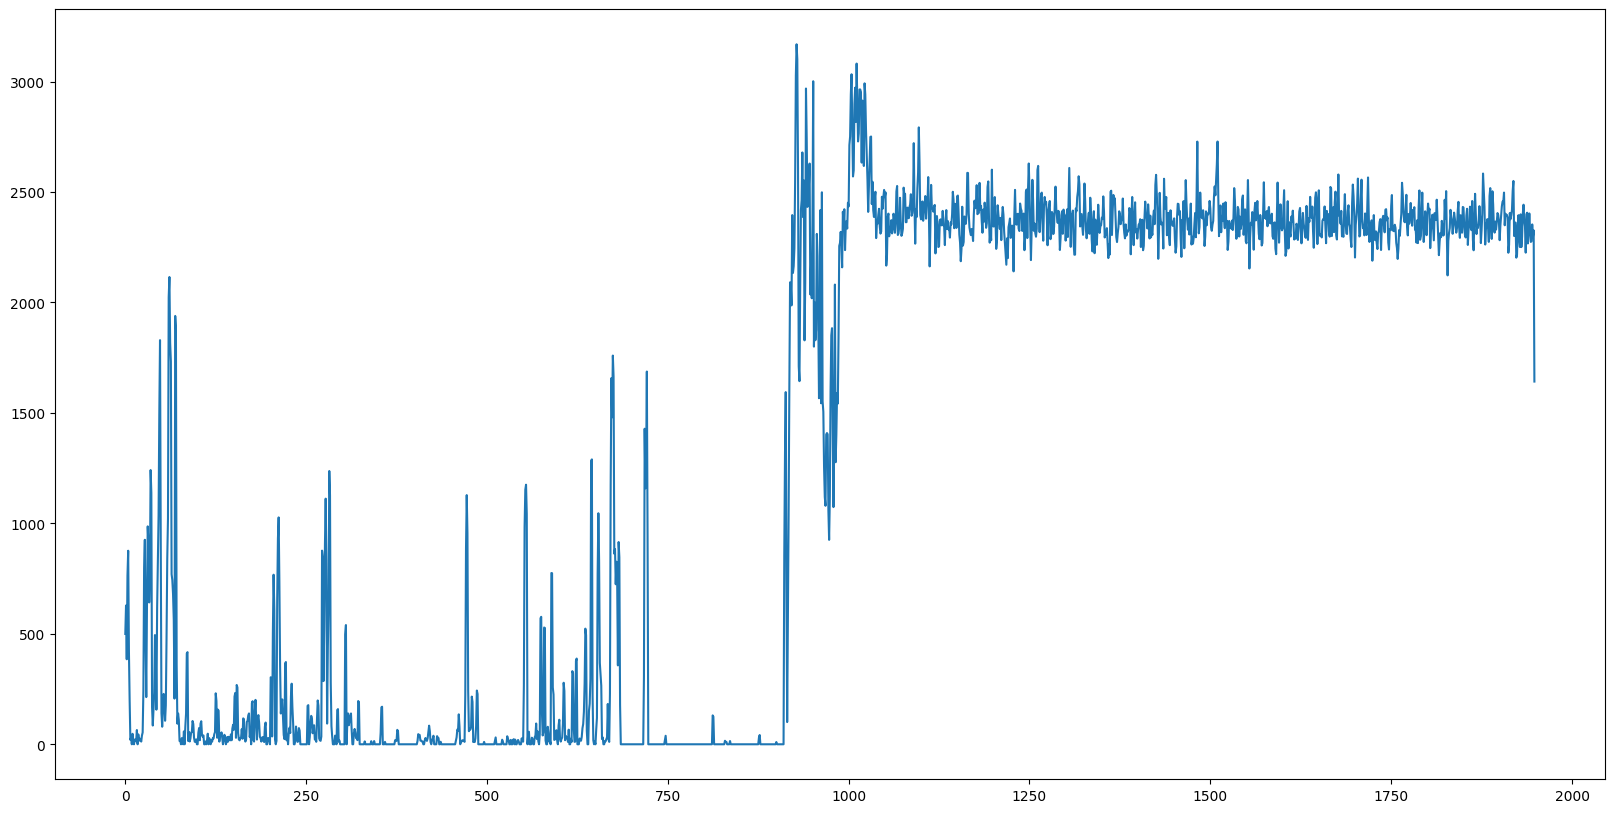

In [213]:
def show_annotation(sel):
    ind = int(sel.target.index)
    frac = sel.target.index - ind
    x, y = sel.target
    sel.annotation.set_text(f'left index:{ind} frac:{frac:.2f}\nx:{x:.2f} y:{y:.2f}')

inputs, labels = torch.load('dataset_ori.pth')
labels[labels < 0] = 0

d = []
# for i in range(len(indexes)-1):
#     for j in range(indexes[i], indexes[i+1]):
#         d.append(euclidean(inputs[j], inputs[j+1]))
#         #plt.plot(inputs[j].numpy())
for j in range(1,1950):
    d.append(euclidean(inputs[j], inputs[j+1]))

# src = inputs[indexes[0]].numpy()
# dst = inputs[indexes[1]].numpy()
# print(src)
# distance = euclidean(src, dst)
print(d)
# plt.plot(inputs[814].numpy())
# plt.plot(inputs[815].numpy())
# plt.legend([814,815])
d = np.array(d)
d[d<10] = 0
plt.plot(d)
plt.show()



In [3]:
import torch
import torch.nn as nn
from collections import OrderedDict

class SignalNet(nn.Module):
    def __init__(self, in_channels = 1, out_channels = 4, features = 8):
        super(SignalNet, self).__init__()
        # fix input size 1280
        self.feature = nn.Sequential(
            SignalNet._block(in_channels, features, name ="enc1"),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(0.1),
            SignalNet._block(features, features * 2, name ="enc2"),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(0.1)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 320, 256),
            nn.Dropout(0.1),
            # target class: noise, signal, transition, leak
            nn.Linear(256, out_channels)
        )

    def forward(self, x):
        x = self.feature(x)
        x = self.fc(x)
        return x
    
    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv1d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm1d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv1d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm1d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

torch.Size([1950, 5, 1280])


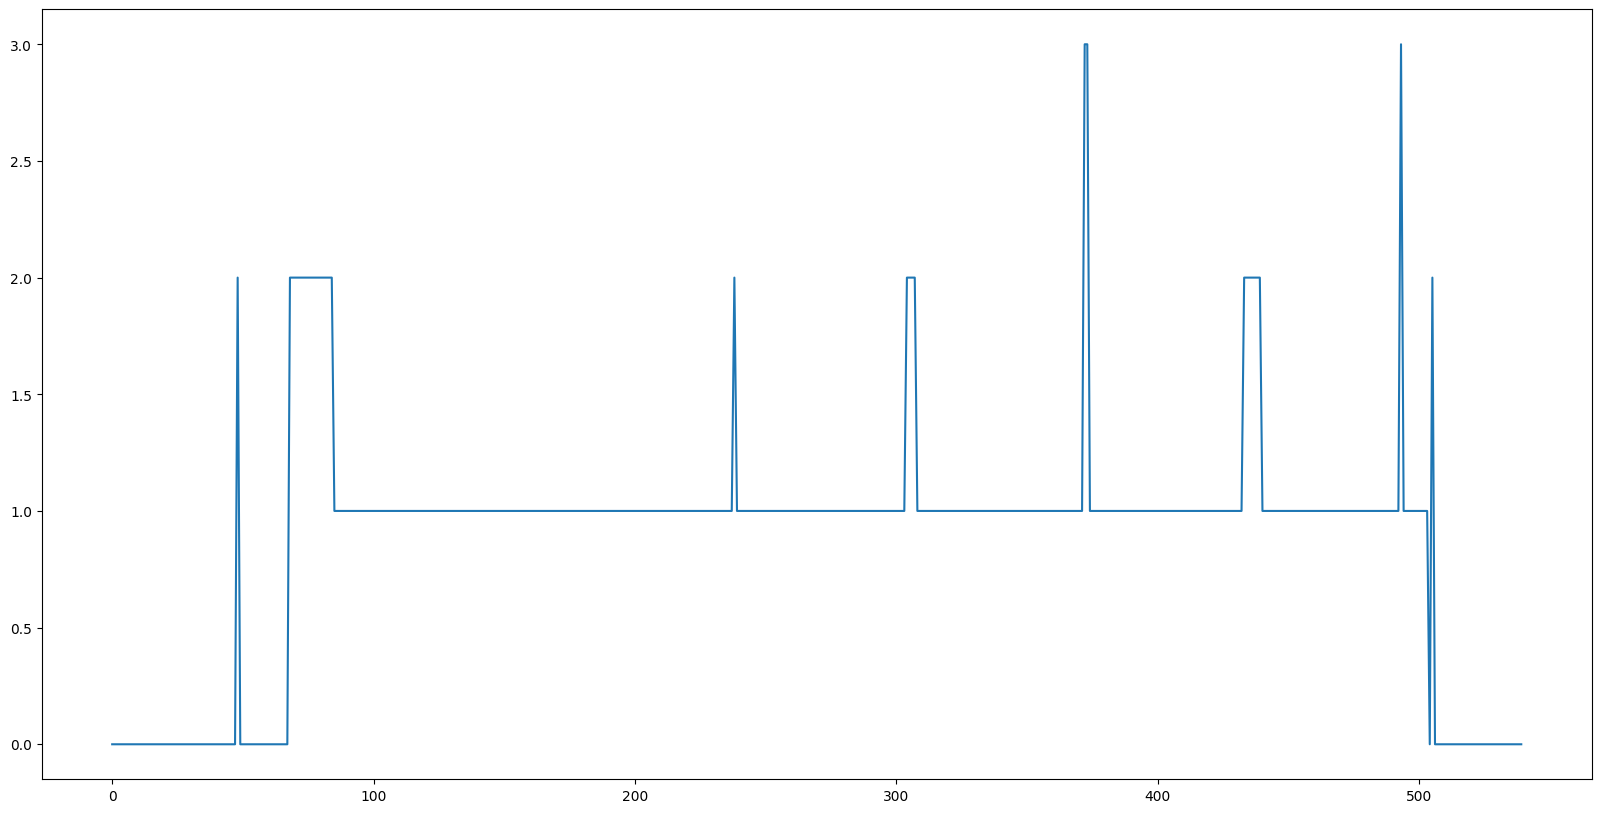

In [261]:
model = SignalNet(in_channels=5)
path = r'C:\\Projects\\MMU\\Ifosic\\src\\Python'
model.load_state_dict(torch.load(f"{path}\\model.pth"))
inputs,labels = torch.load(f"{path}\\dataset.pth")
slice = inputs[1950*2:1950*3]
# x = torch.zeros(roi.shape[0], 1280)
# x[:, :] = roi[:, 840:2120]
# slice = x.unsqueeze(0).permute(1,0,2)
# slice = data_slider(x)
print(slice.shape)
scores = model(slice)
y = torch.argmax(scores, 1)
ty = y[600:1140]
plt.plot(ty)

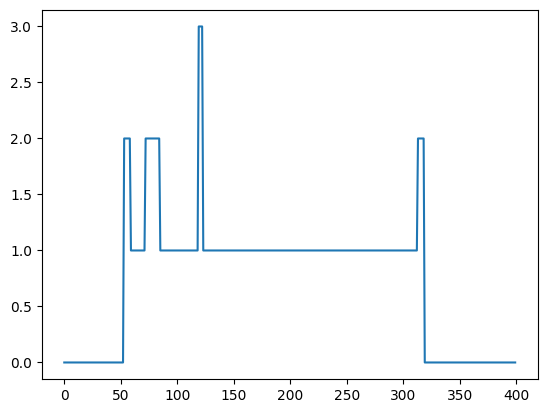

In [ ]:
def data_slider(data: torch.tensor, win = 5):
    h,w = data.shape
    hw = win // 2
    slider = torch.zeros(data.shape[0], win, data.shape[1])
    for i in range(win):
        ss = 0 if i > hw else hw-i
        se = 0 if i < hw else i-hw
        ds = 0 if i < hw else i-hw
        de = 0 if i > hw else hw-i
        # print(ss, se, ds, de)
        slider[ss:h-se,i,:] = data[ds:h-de]
    return slider

slider = data_slider(roi)
model = SignalNet(in_channels=5)
path = r'C:\\Projects\\MMU\\Ifosic\\src\\Python'
model.load_state_dict(torch.load(f"{path}\\model.pth"))
scores = model(slider)
predictedBoundary = torch.argmax(scores, 1)

plt.plot(predictedBoundary)#[600:1000])

1308


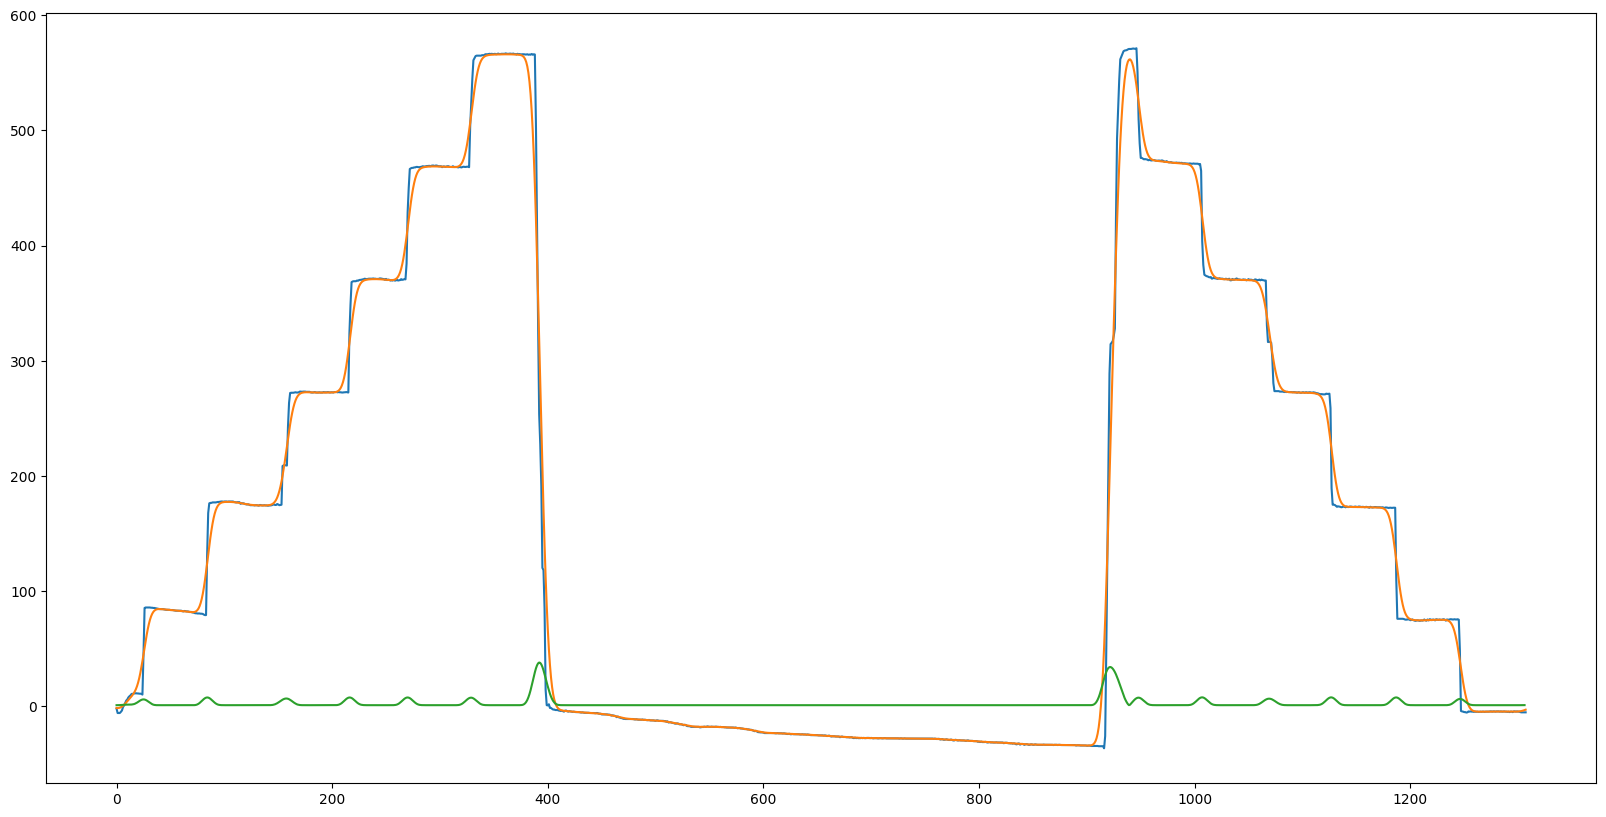

In [203]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

sigma1 = 3
sigma2 = 50

def gaussian_filter1d(size,sigma):
    filter_range = np.linspace(-int(size/2),int(size/2),size)
    gaussian_filter = [1 / (sigma * np.sqrt(2*np.pi)) * np.exp(-x**2/(2*sigma**2)) for x in filter_range]
    return gaussian_filter

fiberId = 5
candidates = []
cTimes = []
average = {}
for i in range(indexes[fiberId - 1], indexes[fiberId]):
    if predictedBoundary[i] != 1:
        continue
    for j in range(traces.shape[0]):
        candidates.append(traces[j,i])
        cTimes.append(j)
        average[j] = average.get(j, 0) + traces[j,i]

times = np.arange(0, traces.shape[0])
freqSum = np.array([average[k] for k in average.keys()])

kernel = gaussian_filter1d(size=len(times),sigma=5)
print(len(kernel))
# freqSmooth = savitzky_golay(freqSum, 51, 3)
freqSmooth = np.convolve(freqSum, kernel, mode='same')
distances = []
for key in range(len(freqSmooth) - 1):
    distances.append(euclidean([key, freqSmooth[key]],[key+1, freqSmooth[key+1]]))

# plt.scatter(times, freqSum)
# plt.scatter(times, freqSmooth)
plt.plot(freqSum)
plt.plot(freqSmooth)
plt.plot(distances)

step_indx = np.argmax(freqSmooth)
# fig,ax = plt.subplots(1,2)
# ax[0].plot(gaussian_filter1d(size=365,sigma=sigma1))
# ax[0].set_title(f'sigma= {sigma1}')
# ax[1].plot(gaussian_filter1d(size=365,sigma=sigma2))
# ax[1].set_title(f'sigma= {sigma2}')
plt.show()

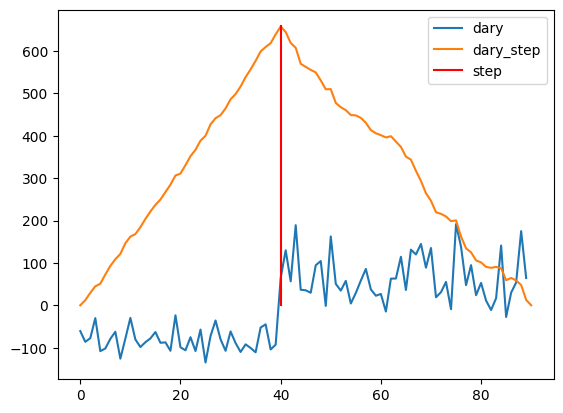

In [62]:
import numpy as np
from matplotlib import pyplot as plt


d = '''594.          568.55555556  577.22222222  624.55555556  546.66666667
552.88888889  575.55555556  592.33333333  528.88888889  576.11111111
625.          574.22222222  556.33333333  567.66666667  576.66666667
591.66666667  566.33333333  567.33333333  547.44444444  631.11111111
555.66666667  548.66666667  579.44444444  546.88888889  597.55555556
519.88888889  582.33333333  618.88888889  574.55555556  547.44444444
593.11111111  565.66666667  544.66666667  562.66666667  554.11111111
543.88888889  602.33333333  609.77777778  550.55555556  561.88888889
719.33333333  784.44444444  711.22222222  843.66666667  691.33333333
690.11111111  684.33333333  749.11111111  759.11111111  653.33333333
817.11111111  705.22222222  689.44444444  712.33333333  659.
683.88888889  713.          740.44444444  692.22222222  677.33333333
681.44444444  640.          717.55555556  717.88888889  769.22222222
690.88888889  786.          774.66666667  799.44444444  743.44444444
789.88888889  673.66666667  685.66666667  709.88888889  645.55555556
846.11111111  792.77777778  702.22222222  749.44444444  678.55555556
707.55555556  665.77777778  643.55555556  671.44444444  795.66666667
627.22222222  684.55555556  708.44444444  829.66666667  719.        '''

dary = np.array([*map(float, d.split())])
dary -= np.average(dary)
step = np.hstack((np.ones(len(dary)), -1*np.ones(len(dary))))
dary_step = np.convolve(dary, step, mode='valid')
# get the peak of the convolution, its index
step_indx = np.argmax(dary_step)  # yes, cleaner than np.where(dary_step == dary_step.max())[0][0]

# plots
plt.plot(dary)
plt.plot(dary_step/10)
plt.plot((step_indx, step_indx), (dary_step[step_indx]/10, 0), 'r')
plt.legend(['dary','dary_step','step'])
plt.show()